In [ ]:
!gdown '1NTN5xFRIJdPpndbadB3pmUZzSqOllNnf'
#https://drive.google.com/file/d/1NTN5xFRIJdPpndbadB3pmUZzSqOllNnf/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1NTN5xFRIJdPpndbadB3pmUZzSqOllNnf
To: /content/data.csv
100% 45.6M/45.6M [00:00<00:00, 98.3MB/s]


# Data Preprocessing:

The choice of encoding (ISO-8859-1) addresses potential issues with character encoding in the dataset. CSV files sometimes contain characters that are not compatible with the default UTF-8 encoding, which can cause errors during import. Using ISO-8859-1 ensures that these characters are correctly interpreted.

In [ ]:
import pandas as pd
#data = pd.read_csv('data.csv', encoding='unicode_escape')
data = pd.read_csv('data.csv', encoding='ISO-8859-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Identifying missing data in the dataset

In [ ]:
# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())
data.head()


Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
data.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Converting InvoiceDate to a datetime format

In [ ]:
# Converting datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [ ]:
x=data[data['StockCode']=='m'].sum()
x

InvoiceNo              539736
StockCode                   m
Description            Manual
Quantity                    1
UnitPrice                2.55
CustomerID                0.0
Country        United Kingdom
dtype: object

Replacing 'm' in StockCode with 'M':
This standardizes the StockCode values. Consistency in categorical data is important for accurate grouping and analysis. This change implies that 'm' and 'M' should be treated as the same stock code.

In [ ]:
#replaced 'm' in StockCode with 'M'
data.loc[ data['StockCode'] == 'm', 'StockCode'] = 'M'
x=data[data['StockCode']=='m'].sum()
x

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

Dropping Rows with Negative Unit Price:
Negative values in UnitPrice are likely to be data errors

In [ ]:
y=data[data['UnitPrice'] < 0]
y

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [ ]:
data.drop(data[data['UnitPrice'] < 0].index, inplace=True)

Dropping Rows with Negative Quantity and Zero Unit Price: This combination is likely erroneous and doesn't contribute to standard sales analysis.

Possible Data Entry Errors: The combination of a negative quantity and a zero unit price is unusual and might indicate a data entry error. In retail datasets, a negative quantity usually reflects returned items, but returns would typically have a non-zero unit price, as they should reverse a previous sale. This inconsistency suggests that these records might not be accurate.

In [ ]:
data_cleaned = data[(data['Quantity'] < 0) & (data['UnitPrice'] == 0)]
data_cleaned.shape

(1336, 8)

In [ ]:
data.drop(data[(data['Quantity'] < 0) & (data['UnitPrice'] == 0)].index, inplace=True)

In [ ]:
#checking if there is any negative quantity and a zero unit price records present
data_cleaned = data[(data['Quantity'] < 0) & (data['UnitPrice'] == 0)]
data_cleaned.shape

(0, 8)

Filling Missing or '?' Descriptions: It ensures that each item has a meaningful and consistent description. This improves the interpretability of the dataset and can be important for understanding product-based patterns in customer behavior.

In [ ]:
# Create a mapping from StockCode to Description
# We use dropna to exclude null descriptions and exclude rows where Description is '?'
valid_descriptions = data[data['Description'].notna() & (data['Description'] != '?')]
description_mapping = valid_descriptions.groupby('StockCode')['Description'].agg(pd.Series.mode).to_dict()

# Fill missing or '?' Descriptions
def fill_description(row):
    if pd.isna(row['Description']) or row['Description'] == '?':
        return description_mapping.get(row['StockCode'], 'Unknown')
    else:
        return row['Description']

data['Description'] = data.apply(fill_description, axis=1)

In [ ]:
#checking if there is any blank description
s= data[data['Description'].isnull()]
s.shape

(0, 8)

In [ ]:
# selecting rows based on condition
rslt_df = data.loc[data['CustomerID'].isnull()]

#printing number of rows in a dataframe where customerid is NULL
rslt_df.shape

(133742, 8)

Handling Missing CustomerIDs

In [ ]:
from random import randint
import numpy as np

# Get unique invoice numbers
stc_cd = rslt_df['InvoiceNo'].unique()
mx_cust = data['CustomerID'].max()

# Set to keep track of generated CustomerIDs
generated_ids = set()

# Function to generate a unique CustomerID
def generate_unique_id():
    while True:
        random_id = int(np.random.randint(mx_cust + 1, mx_cust * 2 + 1))
        if random_id not in generated_ids:
            generated_ids.add(random_id)
            return random_id

# Assigning a unique CustomerID to each InvoiceNo
for i in stc_cd:
    unique_id = generate_unique_id()
    data.loc[data['InvoiceNo'] == i, 'CustomerID'] = unique_id


Converting CustomerID from float to integer

In [ ]:
data["CustomerID"]=data["CustomerID"].astype(int)

In [ ]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

In [ ]:
# Check if there is any missing values
print("\nChecking if there is any more missing values:")
print(data.isnull().sum())


Checking if there is any more missing values:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


# Data Overview

In [ ]:
# Size of the dataset (rows and columns)
dataset_size = data.shape
print(dataset_size)
print("The dataset contains 540571 rows and 8 columns")

(540571, 8)
The dataset contains 540571 rows and 8 columns


In [ ]:
# Description of each column
column_descriptions = data[['UnitPrice','Quantity']].describe()
column_descriptions

,UnitPrice,Quantity
count,540571.000000,540571.000000
mean,4.663454,9.958738
std,94.511739,216.229954
min,0.000000,-80995.000000
25%,1.250000,1.000000
50%,2.080000,3.000000
75%,4.130000,10.000000
max,38970.000000,80995.000000


**Column Descriptions**:
   - **InvoiceNo**: Number assigned to each purchase. Helps track individual transactions.
   - **StockCode**: Code for each product type. Identifies different products.
   - **Description**: Information about the product.
   - **Quantity**: Number of units bought in each transaction.
   - **InvoiceDate**: Date and time of the purchase.
   - **UnitPrice**: Cost per individual unit of the product.
   - **CustomerID**: Customer identification number. Identifies individual customers.
   - **Country**: Country where the customer resides.

In [ ]:
# Time period covered by the dataset
min_date = data['InvoiceDate'].min()
max_date = data['InvoiceDate'].max()
time_period = (min_date, max_date)
print("The minimum time perioid is:\n",data['InvoiceDate'].min(),"\n\nThe maximum time perioid is:\n", data['InvoiceDate'].max())

The minimum time perioid is:
 2010-12-01 08:26:00 

The maximum time perioid is:
 2011-12-09 12:50:00


# Customer Analysis

In [ ]:
unq = data['CustomerID'].nunique()
print(f"There are {unq} unique customers")

There are 6744 unique customers


In [ ]:
ord_per_cust = data.groupby('CustomerID')['InvoiceNo'].nunique()
print("Distribution of the number of orders per customer:")
print(ord_per_cust.value_counts())

Distribution of the number of orders per customer:
1     3685
2      817
3      490
4      377
5      288
      ... 
60       1
81       1
50       1
40       1
62       1
Name: InvoiceNo, Length: 65, dtype: int64


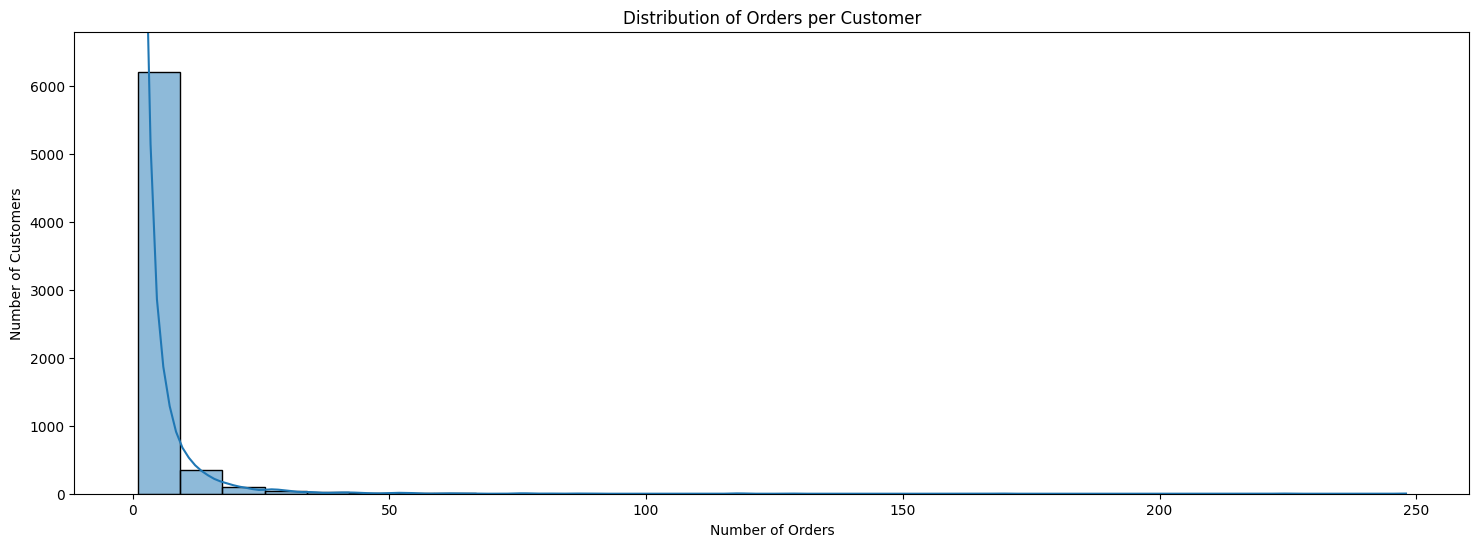

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and axis for the plot
plt.figure(figsize=(18, 6))

# Create a histogram with KDE
sns.histplot(ord_per_cust, bins=30, kde=True)

# Add title and labels
plt.title('Distribution of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylim(0,6800)
plt.ylabel('Number of Customers')

# Show the plot
plt.show()

In [ ]:
top_cust = ord_per_cust.sort_values(ascending=False).head(5)
print("Top 5 customers with the most purchases by order count:")
print(top_cust)

Top 5 customers with the most purchases by order count:
CustomerID
14911    248
12748    224
17841    169
14606    128
15311    118
Name: InvoiceNo, dtype: int64


# Product Analysis

Top 10 Most Frequently Purchased Products: 
Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53847
JUMBO BAG RED RETROSPOT               47363
WHITE HANGING HEART T-LIGHT HOLDER    39317
ASSORTED COLOUR BIRD ORNAMENT         36381
POPCORN HOLDER                        36334
PACK OF 72 RETROSPOT CAKE CASES       36039
RABBIT NIGHT LIGHT                    31496
MINI PAINT SET VINTAGE                26437
PACK OF 12 LONDON TISSUES             26315
PACK OF 60 PINK PAISLEY CAKE CASES    24753
Name: Quantity, dtype: int64 



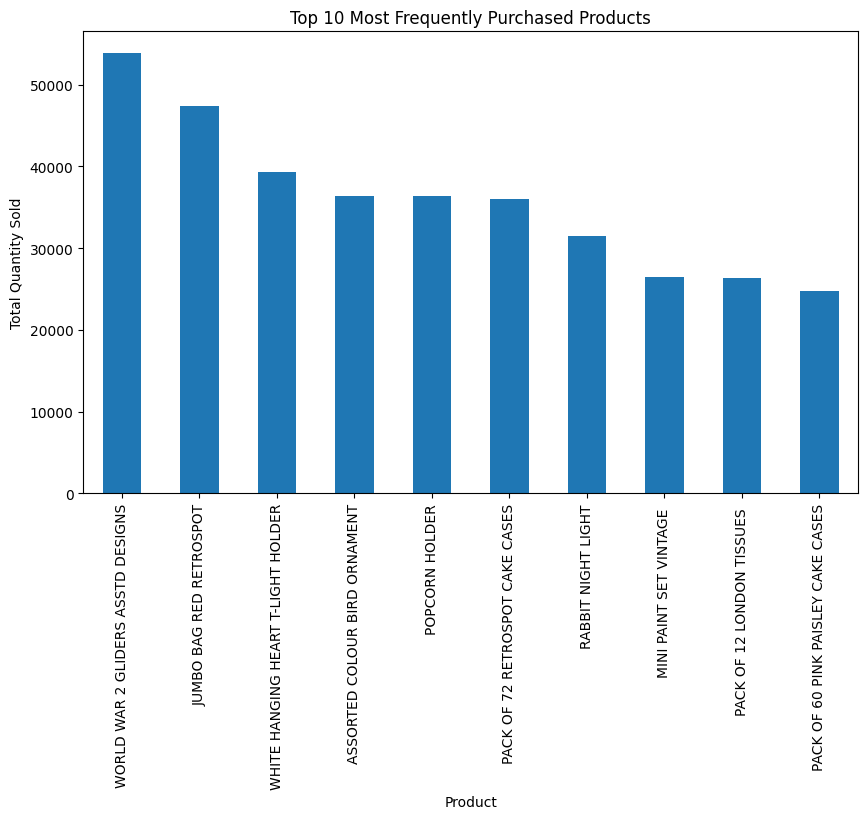


The average price of products in the dataset is:
4.663454188256492 

The product category DOTCOM POSTAGE generated the highest revenue, totaling 206245.48


In [ ]:
# Product Analysis

# Top 10 most frequently purchased products
top_10_products = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Average price of products
average_price = data['UnitPrice'].mean()

# Calculating revenue for each product
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
revenue_per_product = data.groupby('Description')['TotalPrice'].sum()

# top 10 products and average price

print("Top 10 Most Frequently Purchased Products: ")
print(top_10_products,"\n")
# Visualizing the top 10 products
plt.figure(figsize=(10,6))
top_10_products.plot(kind='bar')
plt.title('Top 10 Most Frequently Purchased Products')
plt.xlabel('Product')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=90)
plt.show()
print()
print("The average price of products in the dataset is:")
print(average_price,"\n")

print(f"The product category {revenue_per_product.idxmax()} generated the highest revenue, totaling {revenue_per_product.max()}")


# Time Analysis

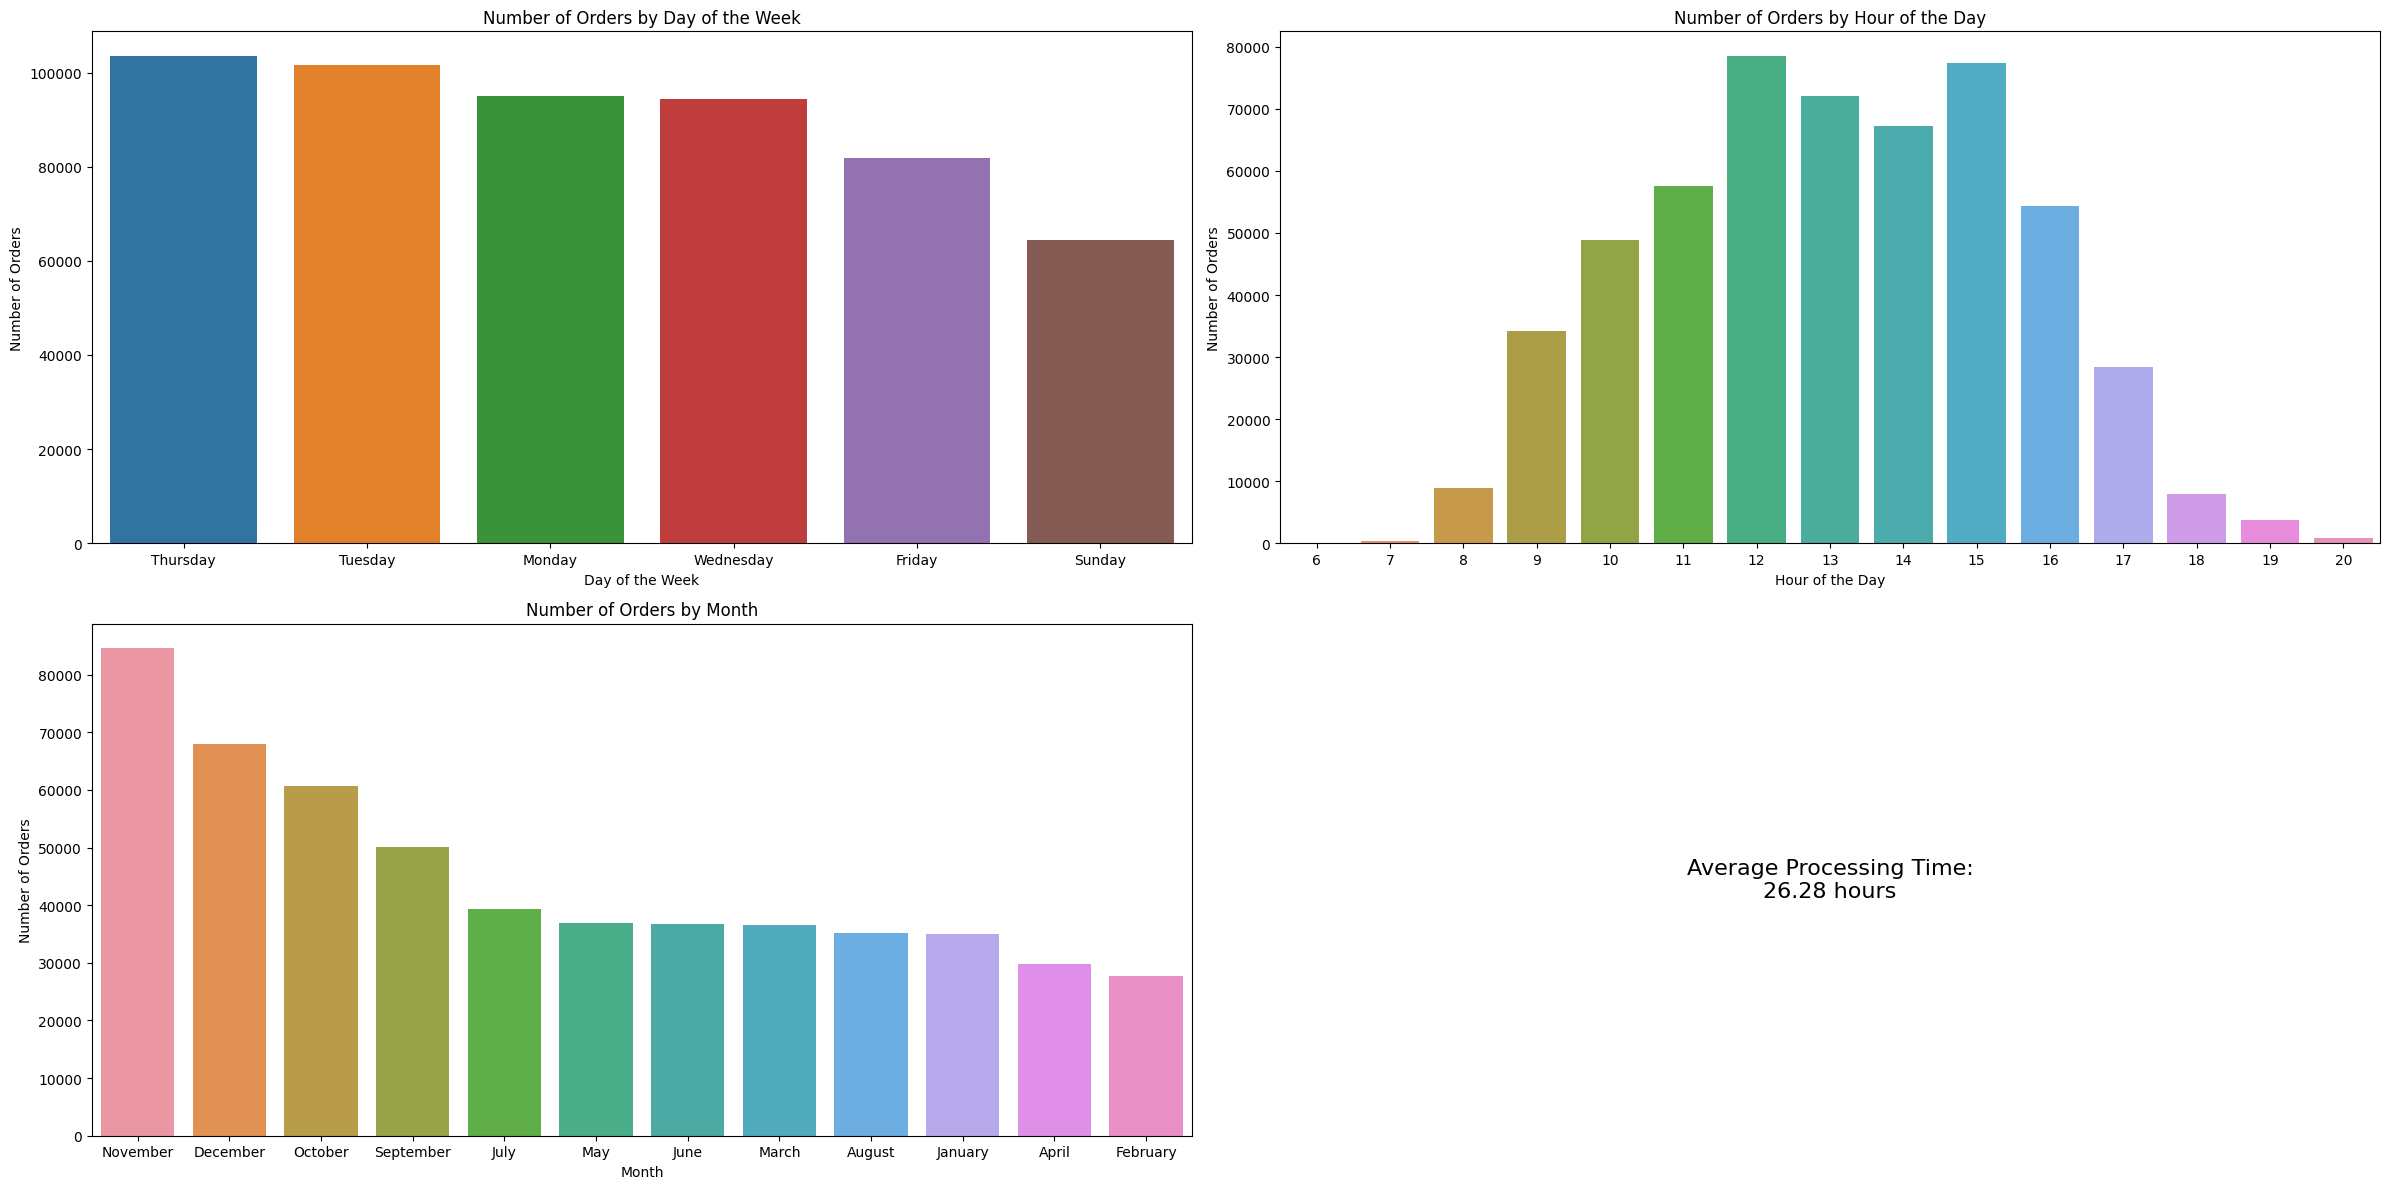

The most common day of the week for orders is Thursday 

The most common hour of the day for orders is 12 

The average processing time between consecutive orders by the same customer is 26.284930011657973 hours



November     84574
December     67906
October      60596
September    50128
July         39401
May          36913
June         36767
March        36614
August       35232
January      35051
April        29730
February     27659
Name: Month, dtype: int64

In [ ]:
from datetime import datetime
import numpy as np

# Converting 'InvoiceDate' to datetime format for analysis
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Time Analysis

# Day of the week and time of day with most orders
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
data['HourOfDay'] = data['InvoiceDate'].dt.hour
most_common_day = data['DayOfWeek'].value_counts().idxmax()
most_common_hour = data['HourOfDay'].value_counts().idxmax()


# Average order processing time
# Assuming processing time is the time difference between consecutive orders by the same customer
data = data.sort_values(by=['CustomerID', 'InvoiceDate'])
data['PreviousInvoiceDate'] = data.groupby('CustomerID')['InvoiceDate'].shift(1)
data['ProcessingTime'] = (data['InvoiceDate'] - data['PreviousInvoiceDate']).dt.total_seconds() / 3600  # in hours
average_processing_time = data['ProcessingTime'].mean()



# Seasonal trends - analyzing orders by month
data['Month'] = data['InvoiceDate'].dt.month_name()
monthly_order_distribution = data['Month'].value_counts()


# Creating subplots to visualize the data side by side
fig, axs = plt.subplots(2, 2, figsize=(24, 12))

# Visualize the number of orders by day of the week
sns.countplot(x='DayOfWeek', data=data, order=data['DayOfWeek'].value_counts().index, ax=axs[0, 0])
axs[0, 0].set_title('Number of Orders by Day of the Week')
axs[0, 0].set_xlabel('Day of the Week')
axs[0, 0].set_ylabel('Number of Orders')

# Visualize the number of orders by hour of the day
sns.countplot(x='HourOfDay', data=data, ax=axs[0, 1])
axs[0, 1].set_title('Number of Orders by Hour of the Day')
axs[0, 1].set_xlabel('Hour of the Day')
axs[0, 1].set_ylabel('Number of Orders')

# Visualize the number of orders by month
sns.countplot(x='Month', data=data, order=data['Month'].value_counts().index, ax=axs[1, 0])
axs[1, 0].set_title('Number of Orders by Month')
axs[1, 0].set_xlabel('Month')
axs[1, 0].set_ylabel('Number of Orders')

# Displaying average processing time in the fourth subplot
axs[1, 1].text(0.5, 0.5, f'Average Processing Time:\n{average_processing_time:.2f} hours',
               fontsize=16, ha='center', va='center')
axs[1, 1].axis('off')

# Adjust layout for better display
plt.tight_layout()
plt.show()




print(f"The most common day of the week for orders is {most_common_day} \n")
print(f"The most common hour of the day for orders is {most_common_hour} \n")

print(f"The average processing time between consecutive orders by the same customer is {average_processing_time} hours\n" )

monthly_order_distribution



**Seasonal Trend:**

November is the busiest month with 84,574 orders.

December follows with 67,906 orders, likely indicating a holiday season peak.

The months with the fewest orders are February (27,659) and April (29,730) , suggesting lower activity in early spring.

# Geographical Analysis

Top 5 Countries with the Highest Number of Orders:
United Kingdom    494140
Germany             9495
France              8557
EIRE                8196
Spain               2533
Name: Country, dtype: int64


Countries with the Highest Average Order Value:
Country
Australia      8359.481644
Netherlands    7631.071324
Israel         3048.575455
Japan          2601.492179
Singapore      2416.252052
Name: OrderValue, dtype: float64


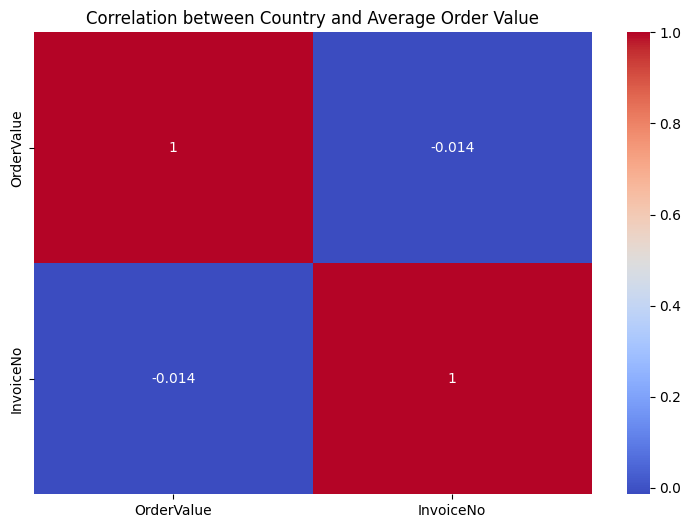

Based on the heatmap, there is no significant correlation between the country of the customer and the average order value


In [ ]:
# Top 5 countries with the highest number of orders
top_5_countries = data['Country'].value_counts().head(5)

# Average order value by country
# Assuming order value is the total price of each order
data['OrderValue'] = data.groupby('InvoiceNo')['TotalPrice'].transform('sum')
average_order_value_by_country = data.groupby('Country')['OrderValue'].mean()


print(f"Top 5 Countries with the Highest Number of Orders:\n{top_5_countries}\n\n")

print(f"Countries with the Highest Average Order Value:\n{average_order_value_by_country.sort_values(ascending=False).head(5)}")



# Calculate average order value per country
#avg_order_value_by_country = df.groupby('Country')['UnitPrice'].mean().reset_index()

# Calculate the number of unique invoices per country
num_invoices_by_country = data.groupby('Country')['InvoiceNo'].nunique().reset_index()

# Merge the two dataframes on the 'Country' column
merged_data = pd.merge(average_order_value_by_country, num_invoices_by_country, on='Country', suffixes=('_avg_order', '_num_invoices'))

# Visualize the correlation
plt.figure(figsize=(9, 6))
sns.heatmap(merged_data[['OrderValue', 'InvoiceNo']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Country and Average Order Value')
plt.show()

print("Based on the heatmap, there is no significant correlation between the country of the customer and the average order value")

# Payment Analysis

The dataset does not contain any columns that explicitly indicate payment methods. Therefore, we cannot perform the Payment Analysis regarding the most common payment methods and their relationship with the order amount.

If there was a column for payment method given to us, we would have grouped the data by payment method let’s say Debit/Credit/Cash. By this we would have gotten more information about customers and preferred choice of payment.

#Returns and Refunds

In [ ]:
# Analyzing Returns and Refunds

# Identifying orders with returns (negative quantities)
returns_data = data[data['Quantity'] < 0]

# Percentage of orders with returns
total_orders = data['InvoiceNo'].nunique()
orders_with_returns = returns_data['InvoiceNo'].nunique()
percentage_returns = (orders_with_returns / total_orders) * 100

# Correlation between product category and returns
returns_by_product = returns_data['Description'].value_counts()

print(f"Approximately {percentage_returns:.2f}% of the orders in the dataset include returns \n")

print(f"Top 10 Product Categories with the Highest Number of Returns:{returns_by_product.head(10)}")

Approximately 15.62% of the orders in the dataset include returns 

Top 10 Product Categories with the Highest Number of Returns:Manual                               244
REGENCY CAKESTAND 3 TIER             181
POSTAGE                              126
JAM MAKING SET WITH JARS              87
Discount                              77
SET OF 3 CAKE TINS PANTRY DESIGN      74
SAMPLES                               61
STRAWBERRY CERAMIC TRINKET BOX        55
ROSES REGENCY TEACUP AND SAUCER       54
RECIPE BOX PANTRY YELLOW DESIGN       47
Name: Description, dtype: int64


# Profitability Analysis

In [ ]:
# Calculating total profit
# Assuming 40% of the TotalPrice for all positive transactions is profit
profit_data = data[data['Quantity'] > 0]
profit_data['ProductProfit'] = profit_data['TotalPrice'] * 0.4
total_profit = profit_data['ProductProfit'].sum()

# Calculating profit for each product
profit_per_product = profit_data.groupby('Description')['ProductProfit'].sum()

# Top 5 products with the highest profit margins
top_5_profit_products = profit_per_product.sort_values(ascending=False).head(5)

print(f"The total profit generated by the company during the dataset's time period is {total_profit:,.2f} \n")

print(f"Top 5 Products with the Highest Profit Margins:\n ")
print(top_5_profit_products)

The total profit generated by the company during the dataset's time period is 4,266,673.82 

Top 5 Products with the Highest Profit Margins:
 
Description
DOTCOM POSTAGE                        82499.508
REGENCY CAKESTAND 3 TIER              69793.896
PAPER CRAFT , LITTLE BIRDIE           67387.840
WHITE HANGING HEART T-LIGHT HOLDER    42517.108
PARTY BUNTING                         39801.732
Name: ProductProfit, dtype: float64


#Customer Satisfaction

Due to the absence of customer feedback or ratings data in the provided dataset, it is not feasible to analyze sentiment or feedback trends. The dataset does not include the essential information, such as customer sentiments, reviews, or numerical ratings, necessary for conducting a meaningful examination of trends related to customer satisfaction. To undertake such an analysis, a dataset with pertinent details on customer comments and ratings would be necessary.


Feedback and Ratings Analysis: It will improve the RFM model by looking at what customers say and how they feel in their feedback. If customers give good feedback or high ratings, they're probably happy and may become loyal. On the other hand, if feedback is negative, these customers might need attention or could stop being customers.


We would have performed Sentiment Analysis:
•	Used natural language processing library like nltk or TextBlob to perform sentiment analysis on customer feedback.
•	Each piece of feedback would be given a sentiment score, typically ranging from negative to positive.


Segment customers:
Segment customers based on RFM values and sentiment scores. This could involve clustering techniques like K-means or simply categorizing based on predefined thresholds.


With both RFM and feedback info, we can create more detailed customer groups, such as:
1. Big spenders who also give positive feedback.
2. Regular but smaller spenders who consistently provide feedback.
3. New customers who spend a lot and give positive feedback.
4. Customers who spend less and either give negative feedback or none at all.


Below Libraries we would have used:
import pandas as pd
from datetime import datetime
from textblob import TextBlob

# RFM Calculation

he RFM metrics have been calculated for each customer:


Recency (R): The number of days since the customer's last purchase. A lower number indicates more recent activity.

Frequency (F): The total number of orders placed by the customer.

Monetary (M): The total monetary value of the customer's purchases.

In [ ]:
df_recency = data
df_recency = df_recency.groupby(by='CustomerID',as_index=False)['InvoiceDate'].max()
df_recency.columns = ['CustomerID','max_date']
df_recency

,CustomerID,max_date
0,12346,2011-01-18 10:17:00
1,12347,2011-12-07 15:52:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00
...,...,...
6739,36520,2011-12-02 12:04:00
6740,36542,2011-09-01 09:03:00
6741,36558,2011-03-18 12:08:00
6742,36573,2011-09-27 12:44:00


In [ ]:
start = data['InvoiceDate'].max() + pd.Timedelta(days=1)

In [ ]:
df_recency['Recency'] = df_recency['max_date'].apply(lambda row: (start - row).days)
df_recency.drop('max_date',inplace=True,axis=1)
df_recency

,CustomerID,Recency
0,12346,326
1,12347,2
2,12348,75
3,12349,19
4,12350,310
...,...,...
6739,36520,8
6740,36542,100
6741,36558,267
6742,36573,74


In [ ]:
df_frequency = data
df_frequency = df_frequency.groupby(by='CustomerID',as_index=False)['InvoiceNo'].nunique()
df_frequency.columns = ['CustomerID','Frequency']
df_frequency

,CustomerID,Frequency
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1
...,...,...
6739,36520,1
6740,36542,1
6741,36558,1
6742,36573,1


In [ ]:
df_monetary = data
# Calculate total price for each transaction
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

df_monetary = df_monetary.groupby(by='CustomerID',as_index=False)['TotalPrice'].sum()
df_monetary.columns = ['CustomerID','Monetary']
data.drop('TotalPrice',inplace=True,axis=1)
df_monetary

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40
...,...,...
6739,36520,0.00
6740,36542,0.00
6741,36558,651.18
6742,36573,1.36


In [ ]:
rfm_df = pd.merge(df_recency[['CustomerID', 'Recency']], df_frequency, on='CustomerID')
rfm_df = pd.merge(rfm_df, df_monetary, on='CustomerID')
rfm_df

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,0.00
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40
...,...,...,...,...
6739,36520,8,1,0.00
6740,36542,100,1,0.00
6741,36558,267,1,651.18
6742,36573,74,1,1.36


# RFM Segmentation

The formula for RFM_Score applies weights to each normalized rank. The choice of weights (0.15 for R, 0.28 for F, and 0.57 for M) should ideally reflect the relative importance of each metric to specific business context.
Multiplying the final score by 0.05 is a scaling choice.

In [ ]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=False)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# Normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['M_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

# Calculation of weighted RFM score
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm'] + 0.28*rfm_df['F_rank_norm'] + 0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)

rfm_df[['CustomerID', 'RFM_Score']].head(7)

,CustomerID,RFM_Score
0,12346,1.07
1,12347,3.65
2,12348,3.15
3,12349,4.30
4,12350,2.70
5,12352,2.85
6,12353,2.30


# Customer Segmentation

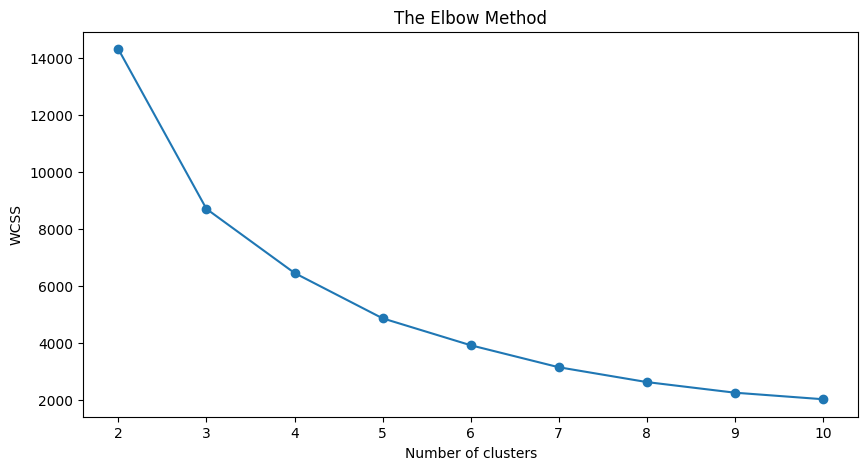

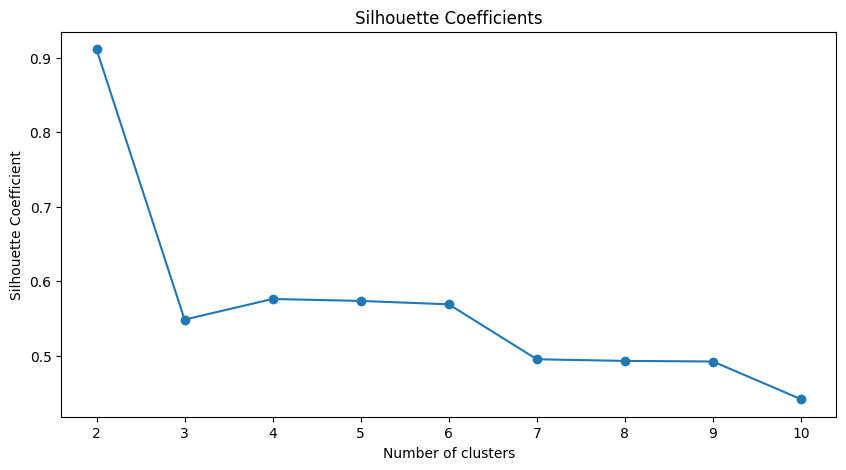

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Normalizing the RFM data
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_normalized, columns=['Recency', 'Frequency', 'Monetary'])


# Finding the optimal number of clusters
wcss = []  # Within-cluster sum of square
silhouette_coefficients = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_normalized)
    wcss.append(kmeans.inertia_)

    # Silhouette score
    score = silhouette_score(rfm_normalized, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Plotting the Silhouette Coefficients
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_coefficients, marker='o')
plt.title('Silhouette Coefficients')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

After running this code, we are able to see the Elbow plot and the Silhouette Coefficients plot, which determines the optimal number of clusters. In an 'elbow' in the WCSS plot where the rate of decrease sharply changes, and for the number of clusters where the silhouette coefficient is highest is 3

While the Silhouette Coefficient suggests that 2 might be the optimal number of clusters for the highest distinctiveness between clusters, the Elbow Method plot does show a bend around 3 clusters, which may indicate a reasonable segmentation despite not being as pronounced.

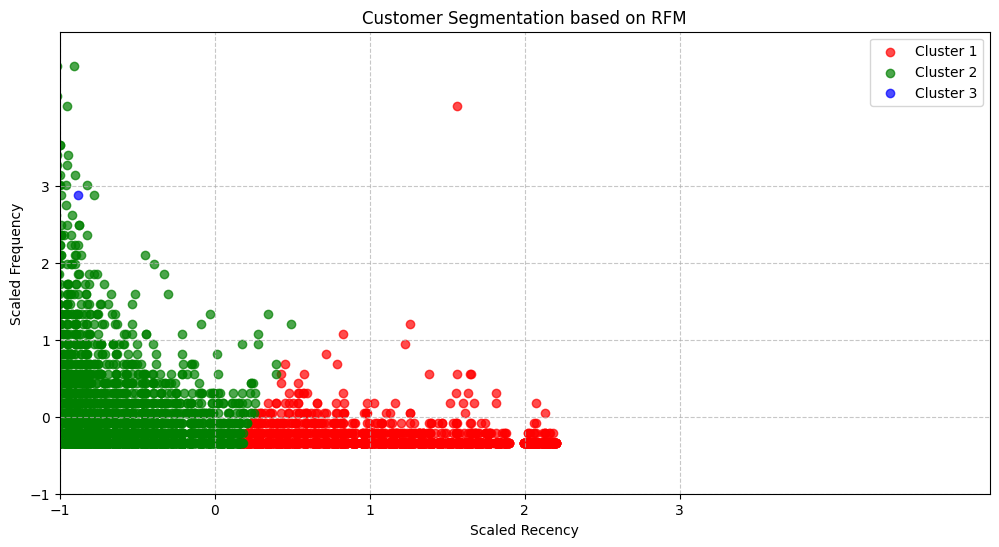

In [ ]:
from sklearn.decomposition import PCA #what is
import seaborn as sns


optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

cluster_colors = ['red','green','blue']


plt.figure(figsize=(12, 6))
for cluster in range(optimal_k):
    cluster_data = rfm_df[rfm_df['Cluster'] == cluster]
    plt.scatter(
        rfm_scaled_df.loc[rfm_df['Cluster'] == cluster, 'Recency'],
        rfm_scaled_df.loc[rfm_df['Cluster'] == cluster, 'Frequency'],
        label=f'Cluster {cluster+1}',
        c=cluster_colors[cluster],
        alpha=0.7
    )

plt.title('Customer Segmentation based on RFM')
plt.xlabel('Scaled Recency')
plt.ylabel('Scaled Frequency')
plt.xticks(np.arange(-1, 4, 1))
plt.yticks(np.arange(-2, 4, 1))
plt.xlim(-1, 5)
plt.ylim(-1, 5)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Segment Profiling

**Defining Customer Segments:**

High Value: Customers with high frequency and monetary scores, and low recency scores.

Medium Value: Customers with moderate frequency and monetary scores.

Low Value: Customers with low frequency and monetary scores, and high recency scores.

In [ ]:
# Applying segmentation with values (3.8 and 2) for RFM Score

rfm_df['Customer_segment'] = np.where(
    rfm_df['RFM_Score'] > 3.8, "High Value Customers",
    np.where(
        rfm_df['RFM_Score'] > 2,
        "Medium Value Customers",
        "Low Value Customers"
    )
)

# Display the first 20 customers with their RFM Score and Customer Segment
rfm_df[['RFM_Score', 'Customer_segment']].head(20)

rfm_df[rfm_df['Monetary']<1]

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Cluster,Customer_segment
0,12346,326,2,0.0,7.20,54.08,9.04,1.07,0,Low Value Customers
89,12454,53,2,0.0,60.41,54.08,14.81,1.63,1,Low Value Customers
125,12503,338,1,-1126.0,5.87,100.00,0.67,1.46,0,Low Value Customers
127,12505,301,1,-4.5,10.96,100.00,3.10,1.57,0,Low Value Customers
170,12558,2,2,0.0,98.39,54.08,14.80,1.92,1,Low Value Customers
...,...,...,...,...,...,...,...,...,...,...
6735,36477,29,1,0.0,73.03,100.00,9.04,2.21,1,Medium Value Customers
6736,36482,101,1,0.0,45.45,100.00,9.04,2.00,1,Low Value Customers
6738,36510,52,1,0.0,61.03,100.00,9.04,2.12,1,Medium Value Customers
6739,36520,8,1,0.0,91.19,100.00,9.04,2.34,1,Medium Value Customers


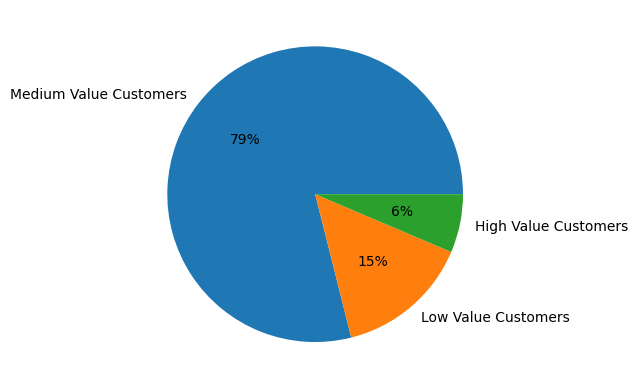

In [ ]:
# Visualization
import matplotlib.pyplot as plt
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

In [ ]:
# Segment Profiling
segment_profile = rfm_df.groupby('Customer_segment').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'RFM_Score': ['mean', 'median']
})

segment_profile

Recency        Frequency            Monetary  \
                              mean median      mean median         mean   
Customer_segment                                                          
High Value Customers    140.835267  102.0  1.030162    1.0  3502.309049   
Low Value Customers     229.625253  235.0  1.382828    1.0  -230.718000   
Medium Value Customers  103.420627   59.0  4.273718    2.0  1594.737492   

                                RFM_Score         
                         median      mean median  
Customer_segment                                  
High Value Customers    2362.83  4.185383   4.12  
Low Value Customers        0.00  1.784131   1.81  
Medium Value Customers   547.70  2.834381   2.84

Based on the RFM scores, customers have been divided into three segments:

1. **High-Value Segment**:
   - Average Recency: 140 days
   - Median Recency: 102 days
   - Average Frequency: 1.03 transactions
   - Median Frequency: 1 transaction
   - Average Monetary Value: 3,502.31
   - Median Monetary Value: 2,362.83
   - Average RFM Score: 4.19
   - Median RFM Score: 4.12

2. **Low-Value Segment**:
   - Average Recency: 229 days
   - Median Recency: 235 days
   - Average Frequency: 1.38 transactions
   - Median Frequency: 1 transaction
   - Average Monetary Value: -230.72
   - Median Monetary Value: 0.00
   - Average RFM Score: 1.78
   - Median RFM Score: 1.81

3. **Medium-Value Segment**:
   - Average Recency: 103 days
   - Median Recency: 59 days
   - Average Frequency: 4.27 transactions
   - Median Frequency: 2 transactions
   - Average Monetary Value: 1,594.74
   - Median Monetary Value: 547.70
   - Average RFM Score: 2.83
   - Median RFM Score: 2.84

# Customer Behavior

In [ ]:
# Calculating the time span from first to last purchase for each customer
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['FirstPurchaseDate'] = data.groupby('CustomerID')['InvoiceDate'].transform('min')
data['LastPurchaseDate'] = data.groupby('CustomerID')['InvoiceDate'].transform('max')
data['CustomerActivePeriod'] = (data['LastPurchaseDate'] - data['FirstPurchaseDate']).dt.days

# Average active period of customers
average_active_period = data['CustomerActivePeriod'].mean()


rfm_scores_present = "RFM_Score" in rfm_df.columns


print(f"On average, customers remain active for approximately {average_active_period: .0f} days between their first and last purchase.")

print(f"\n{rfm_scores_present}: There are customer segments based on their purchase behavior")

On average, customers remain active for approximately  182 days between their first and last purchase.

True: There are customer segments based on their purchase behavior


# Marketing Recommendations

**Low Value Segment:** Focus on increasing transaction frequency and value through targeted offers, product recommendations, and loyalty programs.

**Medium Value Segment:** Encourage more frequent purchases and higher spending through personalized marketing, cross-selling, and up-selling strategies.

**High Value Segment:** Prioritize retention strategies, exclusive services, and personalized experiences to maintain their high engagement and value.


# Visualization

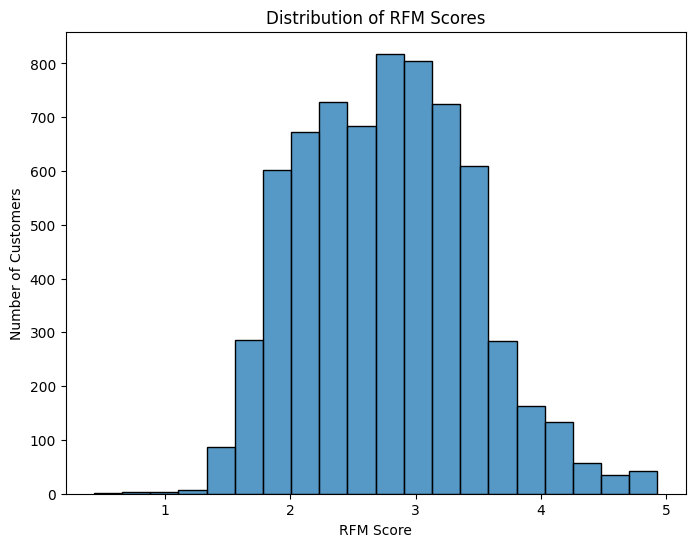

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
plt.figure(figsize=(8, 6))

# RFM Distribution
sns.histplot(rfm_df['RFM_Score'], bins=20, kde=False)
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')

plt.show()


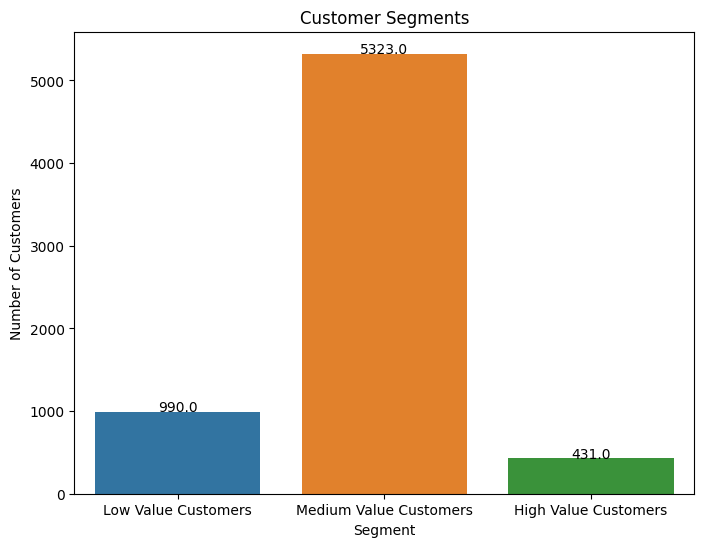

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
plt.figure(figsize=(8, 6))

# Segments
ax = sns.countplot(x='Customer_segment', data=rfm_df, order=['Low Value Customers', 'Medium Value Customers', 'High Value Customers'])
plt.title('Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')

# Display values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()
